In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2538631729245107607
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8578353960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16078319478474613352
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

In [5]:
stock_list = ['Alior Bank', 'Allegro', 'Asseco', 'CCC', 'CD Projekt', 'Cyfrowy Polsat', 'Dino Polska', 'JSW', 'KGHM', 'Lotos', 'LPP', 'Orange Polska', 'PEKAO', 'PGE', 'PGNiG', 'PKN Orlen', 'PKO BP', 'PZU', 'Santander', 'Tauron']

directory = "WiG20 data/"
stock_data_list = []

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    stock_data = pd.read_csv(file_path)
    stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    stock_data['Date'] = pd.to_datetime(stock_data.Date)
    stock_data_list.append(stock_data)
    print('Loaded file: ' + filename)

Loaded file: acp_d.csv
Loaded file: ale_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: cps_d.csv
Loaded file: dnp_d.csv
Loaded file: jsw_d.csv
Loaded file: kgh_d.csv
Loaded file: lpp_d.csv
Loaded file: lts_d.csv
Loaded file: opl_d.csv
Loaded file: peo_d.csv
Loaded file: pge_d.csv
Loaded file: pgn_d.csv
Loaded file: pkn_d.csv
Loaded file: pko_d.csv
Loaded file: pzu_d.csv
Loaded file: san_d.csv
Loaded file: tpe_d.csv


In [6]:
for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

In [7]:
def calculate_technical_indicators(data, rsi_period=10, so_period=14, so_d_period=4, tema_period=10, cgi_period=20, wpi_period=14):
    # rsi_period - number of sessions considered when calculating RSI
    # so_period - number of sessions considered when calculating stochastic oscillator K
    # so_d_period - numbers of sessions considered when calculating moving average of the stochastic oscillator K
    # tema_period - number of sessions considered when calculating TEMA
    # cgi_period - number of sessions considered when calculating CGI
    # wpi_period - number of sessions considered when calculating Williams' Percent Range

    # Moving averages for periods of 10, 30 and 60 days
    data['MovingAverage4'] = data['Close'].rolling(4).mean()
    data['MovingAverage7'] = data['Close'].rolling(7).mean()
    data['MovingAverage20'] = data['Close'].rolling(20).mean()

    # Relative Strength Index RSI
    increase_difference, decrease_difference = data['Close'].diff(), data['Close'].diff()
    increase_difference[increase_difference < 0] = 0
    decrease_difference[decrease_difference > 0] = 0
    roll_increase = increase_difference.ewm(span = rsi_period).mean()
    roll_decrease = decrease_difference.abs().ewm(span = rsi_period).mean()
    RS = roll_increase / roll_decrease
    data['RSI'] = 100 - (100 / (1 + RS))

    # Rate of Change ROC
    data['ROC'] = data['Close'].pct_change()

    # Stochastic Oscillator K
    L14, H14 = data['Close'].rolling(so_period).min(), data['Close'].rolling(so_period).max()
    data['K'] = (data['Close'] - L14)/(H14 - L14)

    # Moving average of the Stochastic Oscillator D
    data['D'] = data['K'].rolling(so_d_period).mean()

    # Moving Average Convergence / Divergence MACD
    EMA_26 = data['Close'].ewm(26, adjust=False).mean()
    EMA_12 = data['Close'].ewm(12, adjust=False).mean()
    data['MACD'] = EMA_12 - EMA_26

    # MACD Signal Line
    data['MACD_Signal'] = data['MACD'].ewm(9, adjust=False).mean()

    # MACD histogram
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

    # Percentage Price Oscillator PPO
    data['PPO'] =(EMA_12 - EMA_26)/EMA_26

    # Triple Exponential Moving Average TEMA
    SEMA = data['Close'].ewm(tema_period, adjust=False).mean()
    DEMA = SEMA.ewm(tema_period, adjust=False).mean()
    data['TEMA'] = DEMA.ewm(tema_period, adjust=False).mean()

    # Commodity Channel Index CGI
    typical_price = (data['Highest'] + data['Lowest'] + data['Close']) / 3
    MA = typical_price.rolling(cgi_period).mean()
    mean_deviation = (MA - typical_price).abs().rolling(cgi_period).mean()
    data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)

    # Williams' Percent Range
    data['Percent_Range'] = (data['Highest'].rolling(wpi_period).max() - data['Close']) / (data['Highest'].rolling(wpi_period).max() - data['Lowest'].rolling(wpi_period).min())

    return data

In [8]:
def scale_data(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [9]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

In [10]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

def evaluate_results(X_valid, Y_valid, Y_scalers, predictions):

    predictions = Y_scalers[0].inverse_transform(predictions)
    real_output = Y_scalers[0].inverse_transform(Y_valid)

    predicted_data = pd.DataFrame(predictions, columns=['Open_predicted', 'Close_predicted', 'Highest_predicted', 'Lowest_predicted', 'Volume_predicted'])
    real_data = pd.DataFrame(real_output, columns=['Open_real', 'Close_real', 'Highest_real', 'Lowest_real', 'Volume_real'])
    predictions = pd.concat([real_data, predicted_data], axis=1)
    print(predictions[['Close_real', 'Close_predicted']].tail(20))

    predictions['Close_difference'] = abs(predictions['Close_real'] - predictions['Close_predicted'])
    predictions['Close_difference_percent'] = abs(predictions['Close_real'] - predictions['Close_predicted'])/predictions['Close_real'] * 100

    previous_close = predictions['Close_real'].shift(-1)
    Naive_forcast_MAPE = (abs(predictions['Close_real'] - previous_close)/predictions['Close_real'] * 100).mean()
    predictions_MAPE = predictions['Close_difference_percent'].mean()

    print('Naive forcast MAE: ' + str(round(abs(previous_close - predictions['Close_real']).mean(),2)))
    print('Predictions MAE: ' + str(round(predictions['Close_difference'].mean(),2)))
    print('Naive forcast MAPE: ' + str(round(Naive_forcast_MAPE,2)) + '%')
    print('Predictions MAPE: ' + str(round(predictions_MAPE,2)) + '%')
    
    return predictions

# Lerning based on prices and volume only

In [11]:
scaled_stocks_basic = []
X_scalers_basic = []
Y_scalers_basic = []

for i in range(len(stock_data_list)):
    # Date is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(stock_data_list[i].drop(columns='Date'))
  
    scaled_stocks_basic.append(scaled_stock)
    X_scalers_basic.append(X_scaler)
    Y_scalers_basic.append(Y_scaler)

In [12]:
X_all_basic = []
Y_all_basic = []
scaled_X_list_basic = []
scaled_Y_list_basic = []

for stock in scaled_stocks_basic:
    X, Y = prepare_input_and_output(stock, 60)
    scaled_X_list_basic.append(np.array(X))
    scaled_Y_list_basic.append(np.array(Y))
    X_all_basic = X_all_basic + X
    Y_all_basic = Y_all_basic + Y

X_all_basic, Y_all_basic = np.array(X_all_basic), np.array(Y_all_basic)
print('Shape of input matrix: ' + str(X_all_basic.shape))
print('Shape of output matrix: ' + str(Y_all_basic.shape))

Shape of input matrix: (76328, 60, 5)
Shape of output matrix: (76328, 5)


In [13]:
from sklearn.model_selection import train_test_split

X_train_basic, X_valid_basic, Y_train_basic, Y_valid_basic = train_test_split(X_all_basic, Y_all_basic, test_size=2667, shuffle=False)


In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 24,925
Trainable params: 24,925
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2302/2302 [==============================] - 19s 5ms/step - loss: 0.0027 - val_loss: 5.1664e-04
Epoch 2/15
2302/2302 [==============================] - 11s 5ms/step - loss: 4.9648e-04 - val_loss: 3.3331e-04
Epoch 3/15
2302/2302 [==============================] - 10s 5ms/step - loss: 4.8382e-04 - val_loss: 3.6573e-04
Epoch 4/15
2302/2302 [==============================]

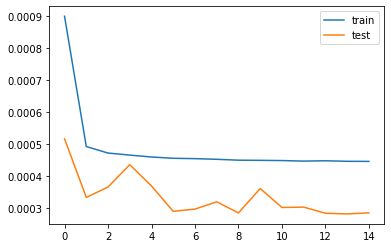

In [15]:
model_basic = Sequential()
model_basic.add(LSTM(64, input_shape=[X_train_basic.shape[1], X_train_basic.shape[2]]))#, return_sequences=True))
#model_basic.add(LSTM(64))
model_basic.add(Dense(100, activation='relu'))
model_basic.add(Dense(Y_train_basic.shape[1]))

model_basic.summary()

model_basic.compile(loss='mse', optimizer='adam')

history = model_basic.fit(X_train_basic, Y_train_basic, epochs=15, validation_data=(X_valid_basic, Y_valid_basic))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
predictions_basic = model_basic.predict(X_valid_basic)

predictions_basic = evaluate_results(X_valid_basic, Y_valid_basic, Y_scalers_basic, predictions_basic) # returns dataset

      Close_real  Close_predicted
2647   43.150455        43.997906
2648   43.190476        44.236675
2649   43.350559        43.566113
2650   44.711269        44.434860
2651   44.190997        45.090874
2652   42.990371        43.267548
2653   42.950351        43.483479
2654   42.590163        43.799892
2655   42.269996        42.736317
2656   42.390058        42.886589
2657   41.949829        42.783558
2658   41.589641        42.610615
2659   40.909286        41.778725
2660   39.628619        41.321568
2661   38.868222        40.015472
2662   37.987763        38.086182
2663   37.987763        38.287563
2664   37.947742        37.709404
2665   38.588076        38.888474
2666   38.387972        38.672997
Naive forcast MAE: 0.83
Predictions MAE: 0.76
Naive forcast MAPE: 1.96%
Predictions MAPE: 1.81%


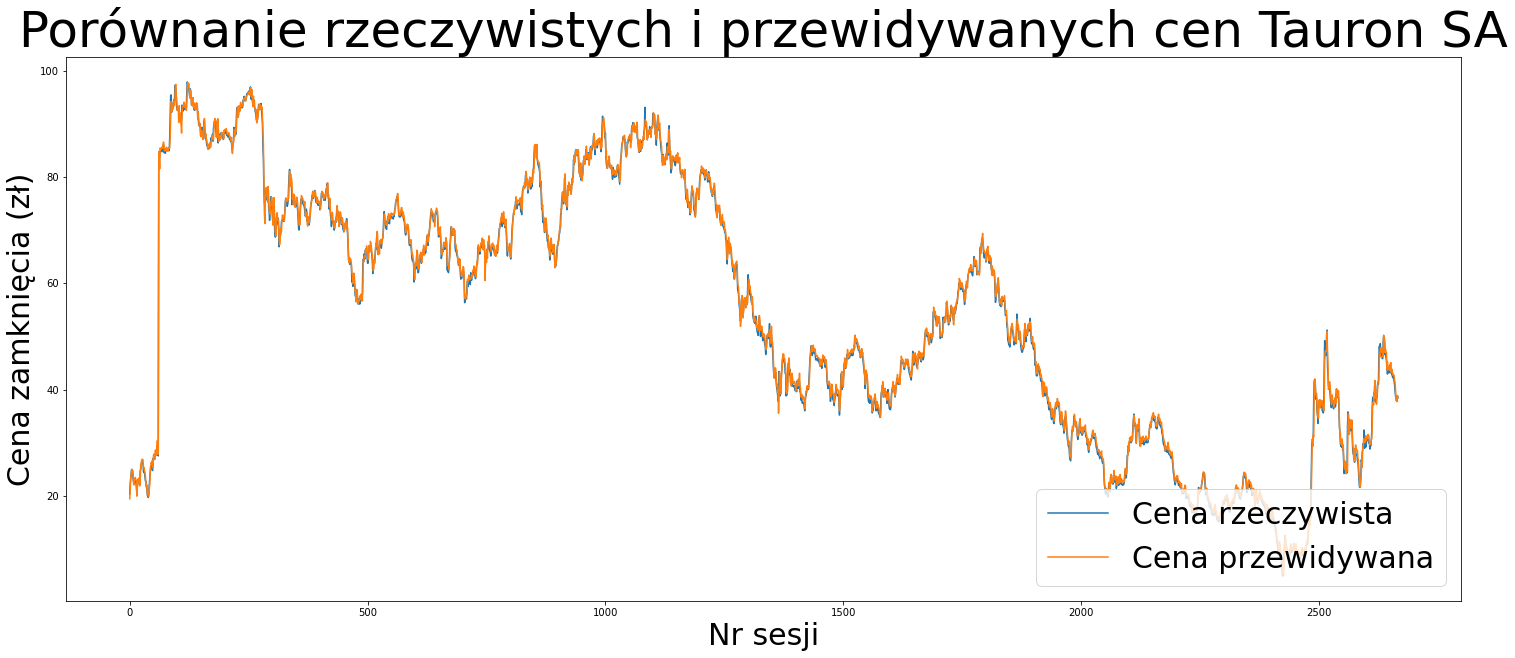

In [17]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions_basic['Close_real'])
plt.plot(predictions_basic['Close_predicted'])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

# Lerning based on prices, volume and technical indicators

In [18]:
from IPython import display
stock_data_list_ta = []

for i in range(len(stock_data_list)):
    technical_indicators = calculate_technical_indicators(stock_data_list[i], rsi_period=60, so_period=5, so_d_period=3, tema_period=4, cgi_period=4, wpi_period=4)
    stock_data_list_ta.append(technical_indicators)
    # moving averages return NaN when the considered period is greater than available data, these rows need to be dropped
    stock_data_list_ta[i] = stock_data_list_ta[i].dropna()

display.display(stock_data_list_ta[0].head(100))

,Date,Open,Highest,Lowest,Close,Volume,MovingAverage4,MovingAverage7,MovingAverage20,RSI,ROC,K,D,MACD,MACD_Signal,MACD_Histogram,PPO,TEMA,CCI,Percent_Range
19,1998-07-01,14.887,14.887,14.887,14.887,200541,14.23250,13.858571,12.91630,73.965805,0.049859,1.000000,1.000000,0.675989,0.377783,0.298206,0.055735,12.524099,10.074074,0.000000
20,1998-07-02,15.160,15.160,15.160,15.160,170204,14.57400,14.115714,13.12075,75.107278,0.018338,1.000000,1.000000,0.744901,0.414495,0.330406,0.060854,12.664168,7.840776,0.000000
21,1998-07-03,15.544,15.544,15.544,15.544,178954,14.94275,14.427714,13.28980,76.599368,0.025330,1.000000,1.000000,0.819350,0.454980,0.364370,0.066273,12.820228,7.385230,0.000000
22,1998-07-06,16.086,16.086,16.086,16.086,204774,15.41925,14.817143,13.43135,78.481622,0.034869,1.000000,1.000000,0.904811,0.499963,0.404848,0.072379,12.994371,7.087901,0.000000
23,1998-07-07,16.526,16.526,16.526,16.526,396111,15.82900,15.207429,13.58690,79.842498,0.027353,1.000000,1.000000,0.995749,0.549542,0.446207,0.078714,13.187914,7.286032,0.000000
24,1998-07-08,16.358,16.358,16.358,16.358,123267,16.12850,15.534429,13.73680,77.897728,-0.010166,0.877013,0.959004,1.067044,0.601292,0.465752,0.083444,13.396623,2.788790,0.171079
25,1998-07-09,15.544,15.544,15.544,15.544,275231,16.12850,15.729286,13.87330,69.426396,-0.049762,0.000000,0.625671,1.094911,0.650654,0.444257,0.084945,13.608569,-7.157234,1.000000
26,1998-07-10,15.544,15.544,15.544,15.544,119449,15.99300,15.823143,14.06160,69.426396,0.000000,0.000000,0.292338,1.116562,0.697245,0.419317,0.085970,13.815615,-6.108844,1.000000
27,1998-07-13,16.631,16.631,16.631,16.631,48999,16.01925,16.033286,14.33960,73.534716,0.069931,1.000000,0.333333,1.175982,0.745118,0.430863,0.089614,14.021141,8.701605,0.000000
28,1998-07-14,17.885,17.885,17.885,17.885,244050,16.40100,16.367714,14.66110,77.190490,0.075401,1.000000,0.666667,1.275467,0.798153,0.477313,0.095906,14.235426,12.646268,0.000000


In [19]:
scaled_stocks_ta = []
X_scalers_ta = []
Y_scalers_ta = []

for i in range(len(stock_data_list_ta)):
    # Date is dropped as it isn't considered for learning
    scaled_stock_ta, X_scaler_ta, Y_scaler_ta = scale_data(stock_data_list_ta[i].drop(columns='Date'))
    scaled_stocks_ta.append(scaled_stock_ta)
    X_scalers_ta.append(X_scaler_ta)
    Y_scalers_ta.append(Y_scaler_ta)

In [20]:
X_all_ta = []
Y_all_ta = []
scaled_X_list_ta = []
scaled_Y_list_ta = []

for stock in scaled_stocks_ta:
    X, Y = prepare_input_and_output(stock)
    scaled_X_list_ta.append(np.array(X))
    scaled_Y_list_ta.append(np.array(Y))
    X_all_ta = X_all_ta + X
    Y_all_ta = Y_all_ta + Y

X_all_ta, Y_all_ta = np.array(X_all_ta), np.array(Y_all_ta)
print('Shape of input matrix: ' + str(X_all_ta.shape))
print('Shape of output matrix: ' + str(Y_all_ta.shape))

Shape of input matrix: (75912, 60, 19)
Shape of output matrix: (75912, 5)


In [21]:
from sklearn.model_selection import train_test_split

X_train_ta, X_valid_ta, Y_train_ta, Y_valid_ta = train_test_split(X_all_ta, Y_all_ta, test_size=2667, shuffle=False)

print('Shape of training input matrix: ' + str(X_train_ta.shape))
print('Shape of training output matrix: ' + str(Y_train_ta.shape))
print('Shape of validation input matrix: ' + str(X_valid_ta.shape))
print('Shape of validation output matrix: ' + str(Y_valid_ta.shape))

Shape of training input matrix: (73245, 60, 19)
Shape of training output matrix: (73245, 5)
Shape of validation input matrix: (2667, 60, 19)
Shape of validation output matrix: (2667, 5)


In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 28,509
Trainable params: 28,509
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2289/2289 [==============================] - 11s 4ms/step - loss: 0.0031 - val_loss: 4.9574e-04
Epoch 2/15
2289/2289 [==============================] - 9s 4ms/step - loss: 6.5930e-04 - val_loss: 3.3601e-04
Epoch 3/15
2289/2289 [==============================] - 9s 4ms/step - loss: 6.2892e-04 - val_loss: 3.1357e-04
Epoch 4/15
2289/2289 [==============================]

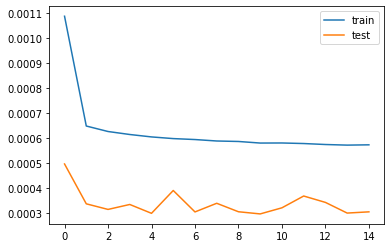

In [23]:
model_ta = Sequential()
model_ta.add(LSTM(64,input_shape=[X_train_ta.shape[1], X_train_ta.shape[2]]))#, return_sequences=True))
model_ta.add(Dense(100, activation='relu'))
model_ta.add(Dense(Y_train_ta.shape[1]))

model_ta.summary()

model_ta.compile(loss='mse', optimizer='adam')

history_ta = model_ta.fit(X_train_ta, Y_train_ta, epochs=15, validation_data=(X_valid_ta, Y_valid_ta))

plt.plot(history_ta.history['loss'], label='train')
plt.plot(history_ta.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
predictions_ta = model_ta.predict(X_valid_ta)

predictions_ta = evaluate_results(X_valid_ta, Y_valid_ta, Y_scalers_ta, predictions_ta)

      Close_real  Close_predicted
2647   43.150455        43.553825
2648   43.190476        43.650494
2649   43.350559        43.079243
2650   44.711269        44.018661
2651   44.190997        44.699780
2652   42.990371        42.936100
2653   42.950351        42.915787
2654   42.590163        43.196281
2655   42.269996        42.261826
2656   42.390058        42.392628
2657   41.949829        42.201668
2658   41.589641        42.075901
2659   40.909286        41.375980
2660   39.628619        40.922291
2661   38.868222        39.863739
2662   37.987763        38.203842
2663   37.987763        37.980537
2664   37.947742        37.635609
2665   38.588076        38.353970
2666   38.387972        38.534252
Naive forcast MAE: 0.84
Predictions MAE: 0.79
Naive forcast MAPE: 2.04%
Predictions MAPE: 1.94%


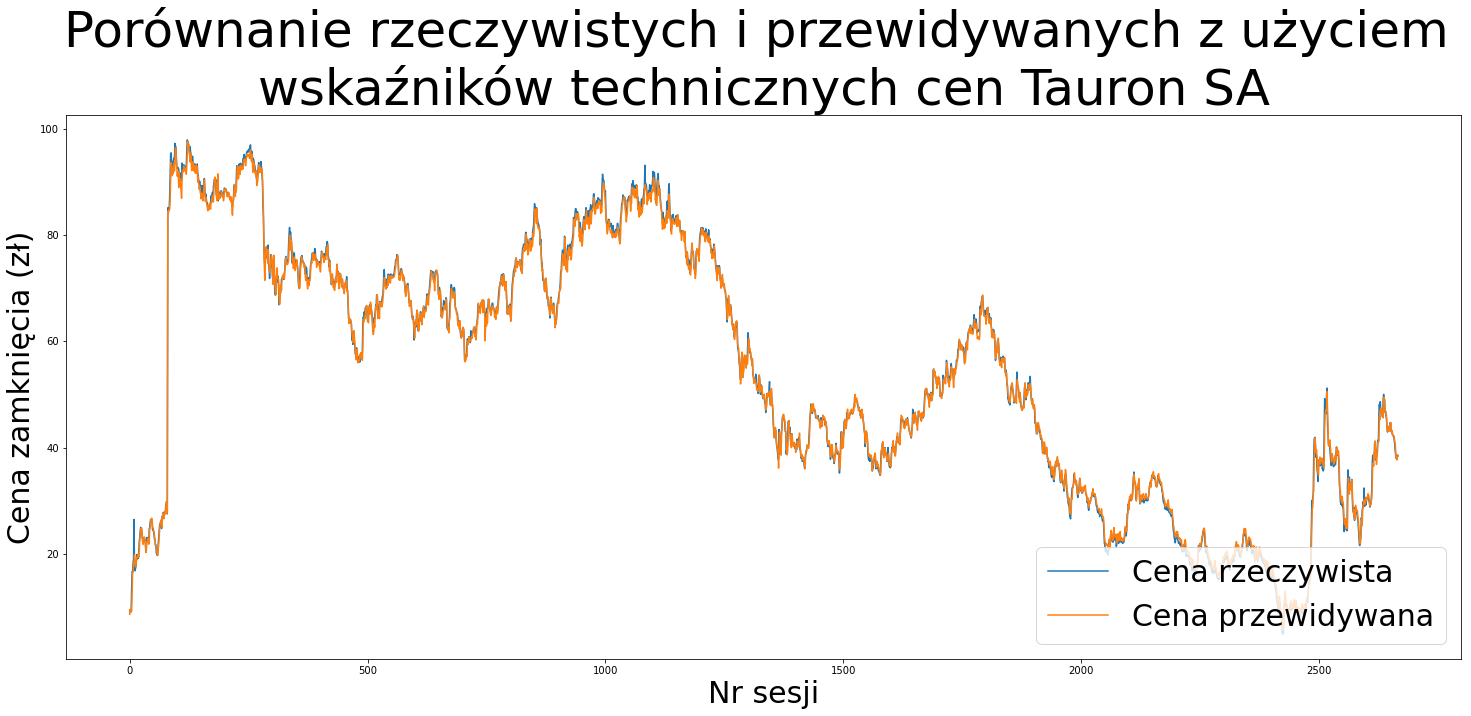

In [25]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych z użyciem \nwskaźników technicznych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions_ta['Close_real'])
plt.plot(predictions_ta['Close_predicted'])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

# Learning based on price, volume and fundamental indicators

In [26]:
fundamental_data = pd.read_csv('Testing_data/WiG20_full_data.csv')

fundamental_data.head()

,Spółka,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Kwartały,Wartość księgowa,Cena/WK,Zysk,Cena/Zysk,Przychód,Cena/Przychód,Zysk operacyjny,Cena/Zysk operacyjny,Wartość księgowa Grahama,Cena/Wartość księgowa Grahama,Wartość przedsiębiorstwa,Wartość przedsiębiorstwa/Przychody,Wartość przedsiębiorstwa/EBIT,Wartość przedsiębiorstwa/EBITDA,ROE,ROA,Marża zysku operacyjnego,...,Zastosowanie kapitału obcego,Wskaźnik ogólnej sytuacji finansowej,Zadłużenie netto,Zadłużenie netto / EBITDA,Zadłużenie finansowe netto,Zadłużenie finansowe netto / EBITDA,I stopień pokrycia,II stopień pokrycia,Płynność gotówkowa,Płynność szybka,Płynność bieżąca,Płynność podwyższona,Pokrycie zobowiązań należnościami,Udział kapitału pracującego w aktywach,Pokrycie kosztów kapitałem obrotowym,Rotacja należności,Cykl należności,Cykl zobowiązań,Rotacja zapasów,Cykl zapasów,Rotacja majątku obrotowego,Rotacja majątku trwałego,Rotacja majątku ogółem,Cykl operacyjny,Cykl konwersji gotówki
0,ACP,2005-02-28,16.358,16.854,16.358,16.526,492612.0,2004/Q4,6.55,2.50,0.02,817.90,23.01,0.71,1.03,15.88,-4.77,-3.43,33.99,1.48,21.97,33.1,0.32,0.08,4.46,...,1.34,0.77,292874000.0,9.04,127506000.0,3.94,0.57,0.93,0.16,0.89,0.96,0.32,0.55,-0.02,-0.04,2.89,126.0,229.0,19.74,18.0,1.66,2.0,0.91,144.0,-85.0
1,ACP,2005-03-01,16.741,16.741,15.979,16.308,293232.0,2004/Q4,6.55,2.56,0.02,837.05,23.01,0.73,1.03,16.25,-4.77,-3.51,33.99,1.48,21.97,33.1,0.32,0.08,4.46,...,1.34,0.77,292874000.0,9.04,127506000.0,3.94,0.57,0.93,0.16,0.89,0.96,0.32,0.55,-0.02,-0.04,2.89,126.0,229.0,19.74,18.0,1.66,2.0,0.91,144.0,-85.0
2,ACP,2005-03-02,16.308,16.414,15.594,15.817,163743.0,2004/Q4,6.55,2.49,0.02,815.40,23.01,0.71,1.03,15.83,-4.77,-3.42,33.99,1.48,21.97,33.1,0.32,0.08,4.46,...,1.34,0.77,292874000.0,9.04,127506000.0,3.94,0.57,0.93,0.16,0.89,0.96,0.32,0.55,-0.02,-0.04,2.89,126.0,229.0,19.74,18.0,1.66,2.0,0.91,144.0,-85.0
3,ACP,2005-03-03,15.817,16.035,15.650,15.650,116137.0,2004/Q4,6.55,2.41,0.02,790.85,23.01,0.69,1.03,15.36,-4.77,-3.32,33.99,1.48,21.97,33.1,0.32,0.08,4.46,...,1.34,0.77,292874000.0,9.04,127506000.0,3.94,0.57,0.93,0.16,0.89,0.96,0.32,0.55,-0.02,-0.04,2.89,126.0,229.0,19.74,18.0,1.66,2.0,0.91,144.0,-85.0
4,ACP,2005-03-04,15.707,15.923,15.650,15.923,48766.0,2004/Q4,6.55,2.40,0.02,785.35,23.01,0.68,1.03,15.25,-4.77,-3.29,33.99,1.48,21.97,33.1,0.32,0.08,4.46,...,1.34,0.77,292874000.0,9.04,127506000.0,3.94,0.57,0.93,0.16,0.89,0.96,0.32,0.55,-0.02,-0.04,2.89,126.0,229.0,19.74,18.0,1.66,2.0,0.91,144.0,-85.0


**Firstly we use stocks that have every fundamental indicator. Indicators like Wartość księgowa Grahama (one among many) don't apply to stocks 'ALR', 'PEO', 'PGN', 'PKO', 'PZU' so we drop them off**

In [27]:
scaled_stocks_fa = []
X_scalers_fa = []
Y_scalers_fa = []

for stock in list(set(fundamental_data['Spółka'].unique()) - set(['ALR', 'PEO', 'PGN', 'PKO', 'PZU', 'SPL'])) :
    # Date, stock and quarters is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(fundamental_data.loc[fundamental_data['Spółka'] == stock].drop(columns=['Spółka', 'Data', 'Kwartały']))
  
    scaled_stocks_fa.append(scaled_stock)
    X_scalers_fa.append(X_scaler)
    Y_scalers_fa.append(Y_scaler)

In [28]:
fundamental_data['Spółka'].unique()

array(['ACP', 'ALE', 'ALR', 'CCC', 'CDR', 'CPS', 'DNP', 'JSW', 'KGHM',
       'LPP', 'LTS', 'OPL', 'PEO', 'PGE', 'PGN', 'PKN', 'PKO', 'PZU',
       'SPL', 'TPE'], dtype=object)

In [29]:
X_all_fa = []
Y_all_fa = []
scaled_X_list_fa = []
scaled_Y_list_fa = []

for stock in scaled_stocks_fa:
    X, Y = prepare_input_and_output(stock, 60)
    scaled_X_list_fa.append(np.array(X))
    scaled_Y_list_fa.append(np.array(Y))
    X_all_fa = X_all_fa + X
    Y_all_fa = Y_all_fa + Y

X_all_fa, Y_all_fa = np.array(X_all_fa), np.array(Y_all_fa)
print('Shape of input matrix: ' + str(X_all_fa.shape))
print('Shape of output matrix: ' + str(Y_all_fa.shape))

Shape of input matrix: (42031, 60, 60)
Shape of output matrix: (42031, 5)


In [30]:
TPE_records = fundamental_data.loc[fundamental_data['Spółka'] == 'TPE'].shape[0]
print('TPE records: ' + str(TPE_records))

TPE records: 2486


In [31]:

# We use one of the stocks data for validation - the TPE which has 2486 records
X_train_fa, X_valid_fa, Y_train_fa, Y_valid_fa = train_test_split(X_all_fa, Y_all_fa, test_size=TPE_records, shuffle=False)

print('Shape of training input matrix: ' + str(X_train_fa.shape))
print('Shape of training output matrix: ' + str(Y_train_fa.shape))
print('Shape of validation input matrix: ' + str(X_valid_fa.shape))
print('Shape of validation output matrix: ' + str(Y_valid_fa.shape))

Shape of training input matrix: (39545, 60, 60)
Shape of training output matrix: (39545, 5)
Shape of validation input matrix: (2486, 60, 60)
Shape of validation output matrix: (2486, 5)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                32000     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 39,005
Trainable params: 39,005
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1236/1236 [==============================] - 6s 4ms/step - loss: 0.0108 - val_loss: 9.9892e-04
Epoch 2/15
1236/1236 [==============================] - 5s 4ms/step - loss: 7.2716e-04 - val_loss: 7.3309e-04
Epoch 3/15
1236/1236 [==============================] - 5s 4ms/step - loss: 6.5865e-04 - val_loss: 8.7818e-04
Epoch 4/15
1236/1236 [==============================] 

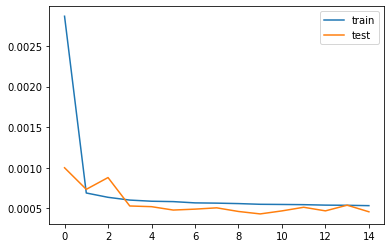

In [32]:
model_fa = Sequential()
model_fa.add(LSTM(64, input_shape=[X_train_fa.shape[1], X_train_fa.shape[2]]))#, return_sequences=True))
#model.add(LSTM(64))
model_fa.add(Dense(100, activation='relu'))
model_fa.add(Dense(Y_train_fa.shape[1]))

model_fa.summary()

model_fa.compile(loss='mse', optimizer='adam')

history_fa = model_fa.fit(X_train_fa, Y_train_fa, epochs=15, validation_data=(X_valid_fa, Y_valid_fa))

plt.plot(history_fa.history['loss'], label='train')
plt.plot(history_fa.history['val_loss'], label='test')
plt.legend()
plt.show()

In [33]:
predictions_fa = model_fa.predict(X_valid_fa)

predictions_fa = evaluate_results(X_valid_fa, Y_valid_fa, Y_scalers_fa, predictions_fa)

      Close_real  Close_predicted
2466   88.636022        88.483635
2467   88.523196        88.650352
2468   89.899665        88.301308
2469   92.291561        91.296112
2470   92.088475        93.019371
2471   92.833122        92.705185
2472   92.178736        92.807037
2473   91.366394        93.474174
2474   92.652602        90.823372
2475   94.344981        94.348198
2476   92.607472        94.092102
2477   96.353271        93.089714
2478   97.797435        95.725723
2479  100.279591        99.048515
2480  100.866282       100.466942
2481   97.481524        97.187180
2482   99.196468        97.541771
2483   93.036208        97.259369
2484   92.156171        90.905128
2485   92.765427        93.949722
Naive forcast MAE: 0.69
Predictions MAE: 0.73
Naive forcast MAPE: 1.35%
Predictions MAPE: 1.44%


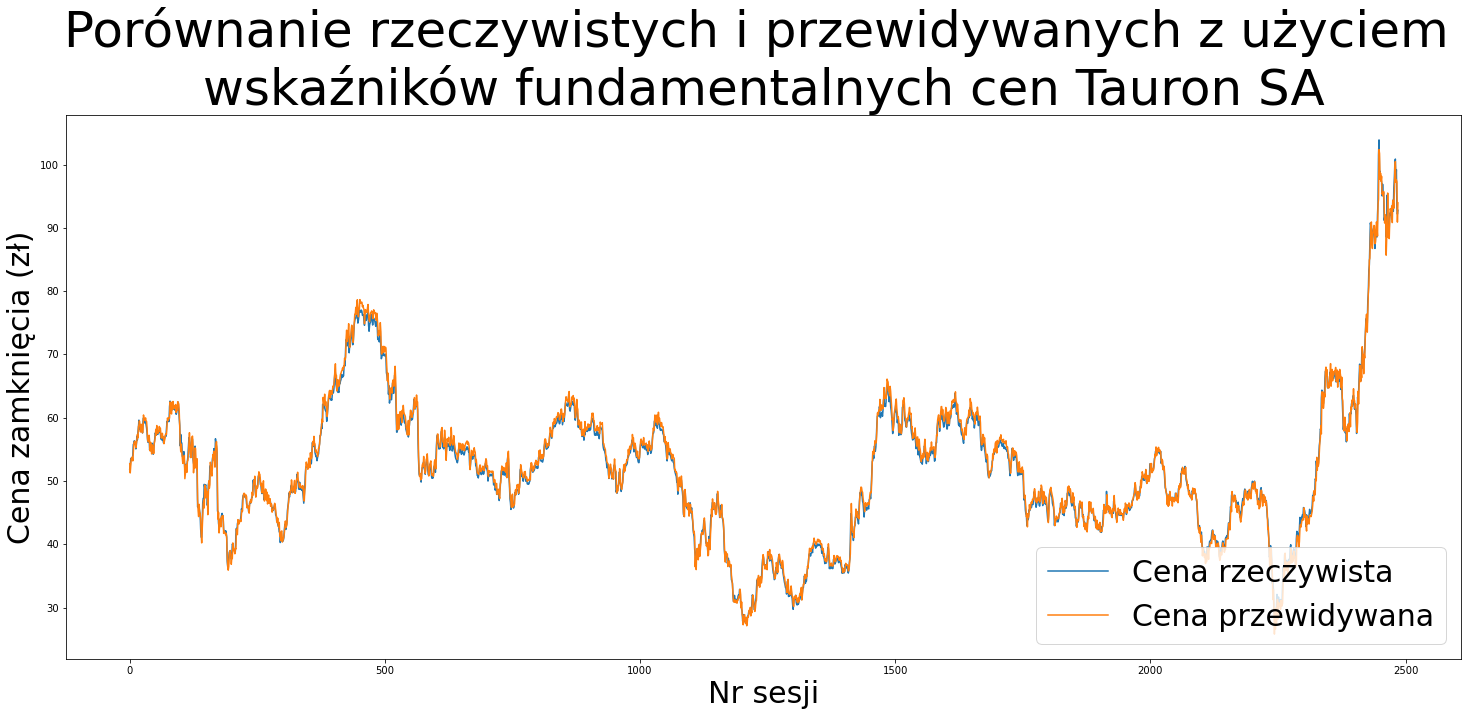

In [34]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych z użyciem \nwskaźników fundamentalnych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions_fa['Close_real'])
plt.plot(predictions_fa['Close_predicted'])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

## From Fundamental indicators tuning.ipynb we've learned that some fundamental indicators are helpful in one-day predictions, so we use them for further testing

In [35]:
scaled_stocks_fa_best = []
X_scalers_fa_best = []
Y_scalers_fa_best = []

list_of_useful_indicators = ['Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen',
                            'Wartość księgowa',
                            'Zysk',
                            'Cena/Przychód',
                            'Cena/Wartość księgowa Grahama',
                            'ROE',
                            'ROA',
                            'Marża zysku operacyjnego',
                            'Marża zysku ze sprzedaży',
                            'Rentowność operacyjna aktywów',
                            'Zadłużenie ogólne',
                            'Zadłużenie kapitału własnego',
                            'Zadłużenie netto',
                            'Płynność gotówkowa',
                            'Płynność podwyższona',
                            'Cykl zobowiązań',
                            'Rotacja majątku obrotowego']

for stock in list(set(fundamental_data['Spółka'].unique()) - set(['ALR', 'PEO', 'PKO', 'SPL'])) :
    # Date, stock and quarters is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(fundamental_data.loc[fundamental_data['Spółka'] == stock, list_of_useful_indicators].dropna())
  
    scaled_stocks_fa_best.append(scaled_stock)
    X_scalers_fa_best.append(X_scaler)
    Y_scalers_fa_best.append(Y_scaler)

In [36]:
X_all_fa_best = []
Y_all_fa_best = []
scaled_X_list_fa_best = []
scaled_Y_list_fa_best = []

for stock in scaled_stocks_fa_best:
    X, Y = prepare_input_and_output(stock, 60)
    scaled_X_list_fa_best.append(np.array(X))
    scaled_Y_list_fa_best.append(np.array(Y))
    X_all_fa_best = X_all_fa_best + X
    Y_all_fa_best = Y_all_fa_best + Y

X_all_fa_best, Y_all_fa_best = np.array(X_all_fa_best), np.array(Y_all_fa_best)
print('Shape of input matrix: ' + str(X_all_fa_best.shape))
print('Shape of output matrix: ' + str(Y_all_fa_best.shape))

Shape of input matrix: (48468, 60, 21)
Shape of output matrix: (48468, 5)


In [37]:

# We use one of the stocks data for validation - the TPE which has 2486 records
X_train_fa_best, X_valid_fa_best, Y_train_fa_best, Y_valid_fa_best = train_test_split(X_all_fa_best, Y_all_fa_best, test_size=TPE_records, shuffle=False)

print('Shape of training input matrix: ' + str(X_train_fa_best.shape))
print('Shape of training output matrix: ' + str(Y_train_fa_best.shape))
print('Shape of validation input matrix: ' + str(X_valid_fa_best.shape))
print('Shape of validation output matrix: ' + str(Y_valid_fa_best.shape))

Shape of training input matrix: (45982, 60, 21)
Shape of training output matrix: (45982, 5)
Shape of validation input matrix: (2486, 60, 21)
Shape of validation output matrix: (2486, 5)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                22016     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 505       
Total params: 29,021
Trainable params: 29,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1437/1437 [==============================] - 7s 4ms/step - loss: 0.0056 - val_loss: 5.6088e-04
Epoch 2/15
1437/1437 [==============================] - 5s 4ms/step - loss: 5.8596e-04 - val_loss: 5.4029e-04
Epoch 3/15
1437/1437 [==============================] - 5s 4ms/step - loss: 5.5016e-04 - val_loss: 5.6509e-04
Epoch 4/15
1437/1437 [==============================] 

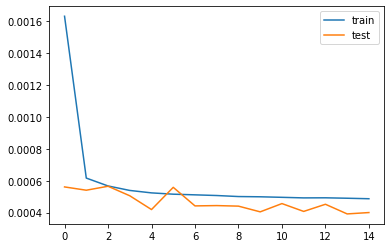

In [38]:
model_fa_best = Sequential()
model_fa_best.add(LSTM(64, input_shape=[X_train_fa_best.shape[1], X_train_fa_best.shape[2]]))#, return_sequences=True))
#model.add(LSTM(64))
model_fa_best.add(Dense(100, activation='relu'))
model_fa_best.add(Dense(Y_train_fa_best.shape[1]))

model_fa_best.summary()

model_fa_best.compile(loss='mse', optimizer='adam')

history_fa_best = model_fa_best.fit(X_train_fa_best, Y_train_fa_best, epochs=15, validation_data=(X_valid_fa_best, Y_valid_fa_best))

plt.plot(history_fa_best.history['loss'], label='train')
plt.plot(history_fa_best.history['val_loss'], label='test')
plt.legend()
plt.show()

In [39]:
predictions_fa_best = model_fa_best.predict(X_valid_fa_best)

predictions_fa_best = evaluate_results(X_valid_fa_best, Y_valid_fa_best, Y_scalers_fa_best, predictions_fa_best)

      Close_real  Close_predicted
2466   27.903022        28.163918
2467   27.877749        28.015837
2468   28.186085        27.936932
2469   28.721884        28.695238
2470   28.676391        28.978247
2471   28.843196        28.966869
2472   28.696610        28.921162
2473   28.514641        29.162945
2474   28.802759        28.577549
2475   29.181861        29.221258
2476   28.792649        29.281889
2477   29.631730        29.063927
2478   29.955231        29.517059
2479   30.511248        30.485685
2480   30.642670        30.712761
2481   29.884465        29.926085
2482   30.268622        30.158312
2483   28.888689        29.899183
2484   28.691555        28.775187
2485   28.828032        29.190517
Naive forcast MAE: 0.15
Predictions MAE: 0.19
Naive forcast MAPE: 0.78%
Predictions MAPE: 0.97%


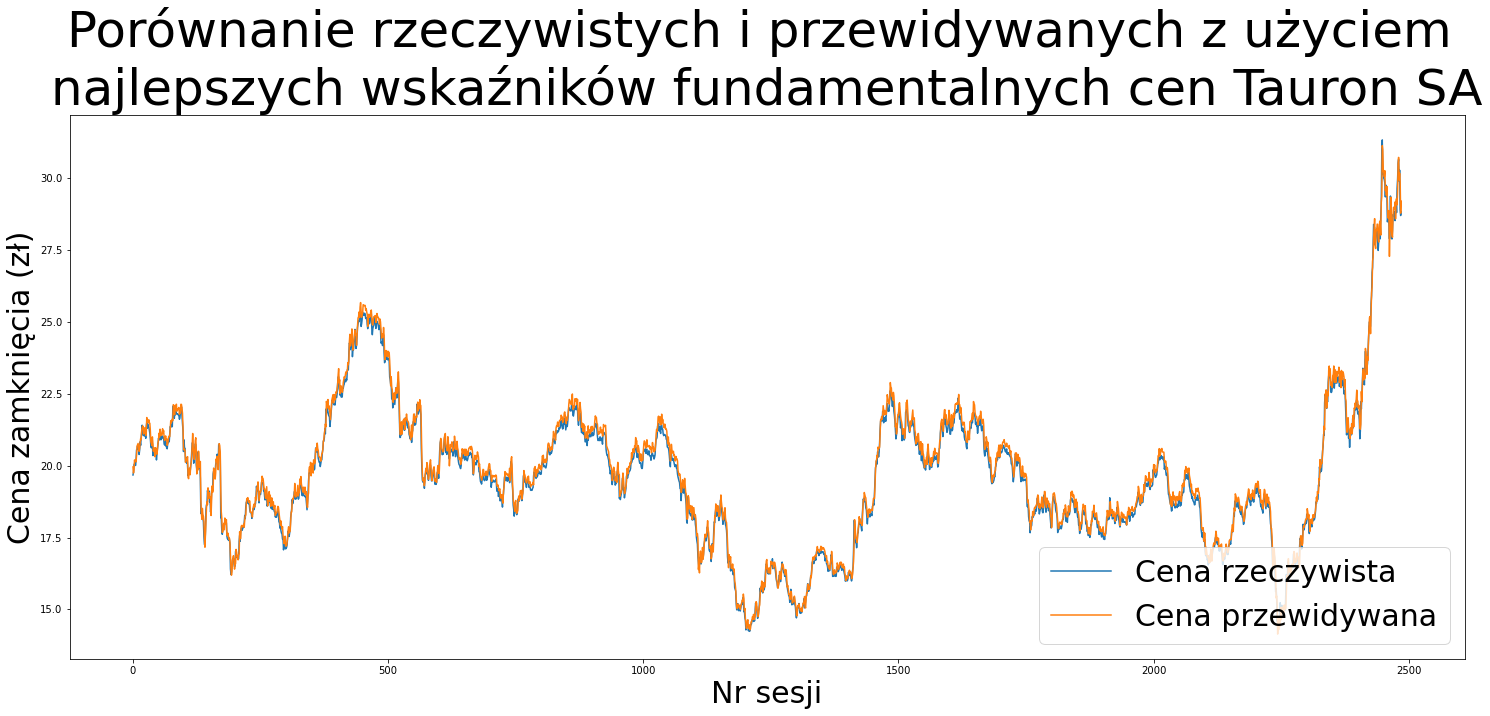

In [40]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych z użyciem \nnajlepszych wskaźników fundamentalnych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions_fa_best['Close_real'])
plt.plot(predictions_fa_best['Close_predicted'])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()